In [12]:
import os

In [13]:
%pwd

'/Users/rociocuatecontzi/Desktop/programming/electricity-forecast'

In [4]:
os.chdir('../')


In [5]:
%pwd

'/Users/rociocuatecontzi/Desktop/programming/electricity-forecast'

In [6]:
from src.eForecaster.pipeline.prediction import PredictionPipeline
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt

In [7]:
moment_to_pred = [['2023-02-13 10:15:00']]
df = pd.DataFrame(moment_to_pred, columns=['datetime'])
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M:%S")

df2 = pd.DataFrame()
df2['hour'] = df['datetime'].dt.hour
df2['dayofweek'] = df['datetime'].dt.dayofweek
df2['quarter']  = df['datetime'].dt.quarter
df2['month']  = df['datetime'].dt.month
df2['year']  = df['datetime'].dt.year
df2['dayofyear']  = df['datetime'].dt.dayofyear
df2['minute']  = df['datetime'].dt.minute
#data = [hour[0], dayofweek[0], quarter[0], month[0], year[0], dayofyear[0], minute[0]]
#print(data)
#data = np.array(data).reshape(1, 7)


In [37]:
import os
import pandas as pd
import numpy as np
import joblib
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
#from src.eForecaster.entity.config_entity import PlotConfig
#from src.eForecaster.config.configuration import ConfigurationManager
from src.eForecaster import logger
from pathlib import Path
from dataclasses import dataclass
from src.eForecaster.constants import *
from eForecaster.utils.common import read_yaml, create_directories

@dataclass(frozen=True)
class PlotConfig:
    root_dir: Path
    model_path: Path
    test_data_path: Path
    scatterplot_path: Path
    target_column: str
    columns: str

class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)
        create_directories([self.config.artifacts_root])

    def get_plot_config(self) -> PlotConfig:
        config = self.config.plotting

        schema = self.schema
        create_directories([
            Path(config.root_dir)
        ])
        plot_config = PlotConfig(
            root_dir=config.root_dir,
            model_path = config.model_path,
            test_data_path = config.test_data_path,
            scatterplot_path = config.scatterplot_path,
            target_column = schema.TARGET_COLUMN.name,
            columns = schema.COLUMNS
        )
        return plot_config


class Plotting:
    def __init__(self, config: PlotConfig):
        self.config = config
    def create_datetime_df(self, start_date: str, end_date: str):
        start_date = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
        end_date = datetime.strptime(end_date,"%Y-%m-%d %H:%M:%S")
        datetime_df = pd.date_range(start_date, end_date, freq='15min')
        datetime_df = datetime_df.to_frame(index=False, name="datetime")
        return datetime_df
    
    def create_prediction_df(self, df):
        df['hour'] = df.datetime.dt.hour
        df['dayofweek'] = df.datetime.dt.dayofweek
        df['quarter'] = df.datetime.dt.quarter
        df['month'] = df.datetime.dt.month
        df['year'] = df.datetime.dt.year
        df['dayofyear'] = df.datetime.dt.dayofyear
        df['minute'] = df.datetime.dt.minute
        return df
        

    def get_prediction(self, df):
        df_copy = df.copy()
        model = joblib.load(self.config.model_path)
        df_to_predict = df[[item for item in self.config.columns.keys()]]
        prediction = model.predict(df_to_predict)
        df_copy['prediction'] = prediction
        return df_copy
    

    def get_scatterplot(self, df):
        ax = sns.scatterplot(data=df, x='datetime', y='prediction')
        plt.title('placeholder title')
        plt.savefig(Path(self.config.scatterplot_path))
        plt.show()
        plt.clf()

[2024-02-13 20:39:16,516: INFO: 1504122080: >>>>>> stage Plotting started <<<<<<]
[2024-02-13 20:39:16,525: INFO: common: yaml file: config/config.yaml loaded successfully]
[2024-02-13 20:39:16,528: INFO: common: yaml file: params.yaml loaded successfully]
[2024-02-13 20:39:16,531: INFO: common: yaml file: schema.yaml loaded successfully]
[2024-02-13 20:39:16,532: INFO: common: created directory at: artifacts]
[2024-02-13 20:39:16,533: INFO: common: created directory at: artifacts/plotting]


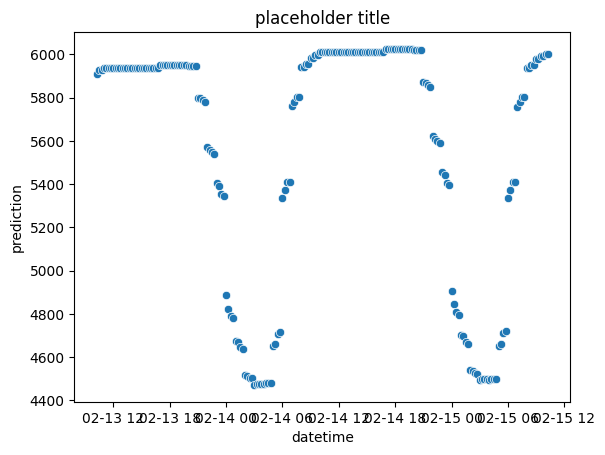

               datetime  hour  dayofweek  quarter  month  year  dayofyear  \
0   2023-02-13 10:15:00    10          0        1      2  2023         44   
1   2023-02-13 10:30:00    10          0        1      2  2023         44   
2   2023-02-13 10:45:00    10          0        1      2  2023         44   
3   2023-02-13 11:00:00    11          0        1      2  2023         44   
4   2023-02-13 11:15:00    11          0        1      2  2023         44   
..                  ...   ...        ...      ...    ...   ...        ...   
188 2023-02-15 09:15:00     9          2        1      2  2023         46   
189 2023-02-15 09:30:00     9          2        1      2  2023         46   
190 2023-02-15 09:45:00     9          2        1      2  2023         46   
191 2023-02-15 10:00:00    10          2        1      2  2023         46   
192 2023-02-15 10:15:00    10          2        1      2  2023         46   

     minute   prediction  
0        15  5911.859375  
1        30  5927.017

<Figure size 640x480 with 0 Axes>

In [38]:
STAGE_NAME = "Plotting"
class PlottingPipeline:
    def __init__(self):
        pass

    def main(self):
        config = ConfigurationManager()
        plot_config = config.get_plot_config()
        plotting = Plotting(config=plot_config)
        datetime_df = plotting.create_datetime_df("2023-02-13 10:15:00", "2023-02-15 10:15:00")
        prediction_df = plotting.create_prediction_df(datetime_df)
        predicted_df = plotting.get_prediction(prediction_df)
        plotting.get_scatterplot(predicted_df)
        #print(datetime_df)
        print(predicted_df)


if __name__ == '__main__':
    try:
        logger.info(f">>>>>> stage {STAGE_NAME} started <<<<<<")
        obj = PlottingPipeline()
        obj.main()
        logger.info(f">>>>>> stage {STAGE_NAME} completed <<<<<<\n\nx==========x")
    except Exception as e:
        logger.exception(e)
        raise e

In [76]:
#datetime_object = datetime.strptime(moment_to_pred, "%Y-%m-%d %H:%M:%S")
#datetime_object

TypeError: strptime() argument 1 must be str, not list

In [90]:
print(moment_to_pred)

[['2023-02-13 10:15:00']]


In [91]:
df2

,hour,dayofweek,quarter,month,year,dayofyear,minute
0,10,0,1,2,2023,44,15


In [92]:
obj = PredictionPipeline()
predict = obj.predict(df2)
print(predict)

[5911.8594]


In [73]:
print(str(predict))

[5324.0454]


In [10]:
from eForecaster.constants import *
from eForecaster.utils.common import read_yaml, create_directories, save_json


In [23]:

config_filepath = CONFIG_FILE_PATH,
params_filepath = PARAMS_FILE_PATH,
schema_filepath = SCHEMA_FILE_PATH

schema = read_yaml(schema_filepath)


schema2 =  schema.TARGET_COLUMN.name
schema3 = []
for item in schema.COLUMNS.keys():
    schema3.append(item)
schema4 = [item for item in schema.COLUMNS.keys()]

print(schema2)
print(schema3)
print(schema4)

[2024-01-28 13:32:33,578: INFO: common: yaml file: schema.yaml loaded successfully]
power
['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'minute']
['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'minute']
